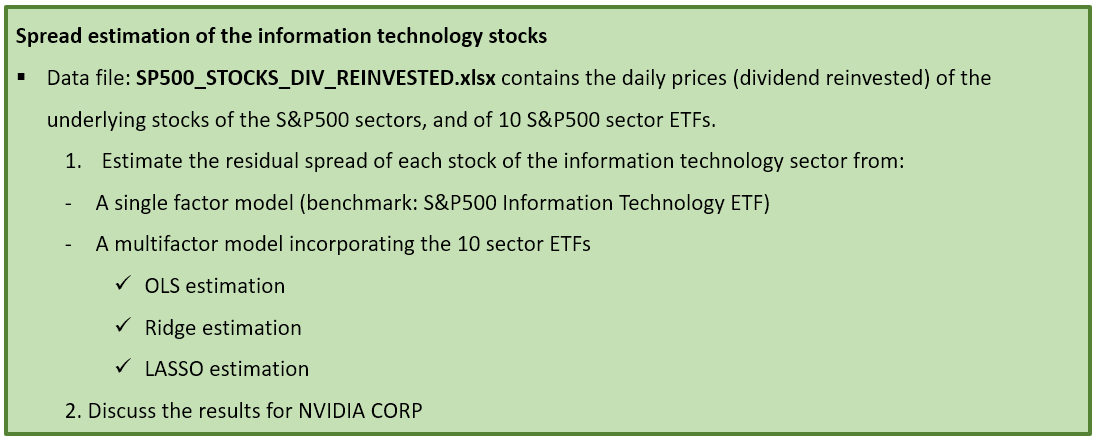

Import Libraries and data

In [20]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import lasso_path

In [2]:
STOCK_PRICES=pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', 'Information Technology',usecols='B:BN')
NAMES=list(STOCK_PRICES)
STOCK_PRICES=np.array(STOCK_PRICES)
ETF_PRICES=pd.read_excel('SP500_STOCKS_DIV_REINVESTED.xlsx', 'Sectors ETFs',usecols='B:K')
SECTORS=list(ETF_PRICES)
ETF_PRICES=np.array(ETF_PRICES)

Computation of daily returns

In [3]:
STOCK_RETURNS=STOCK_PRICES[1:,:]/STOCK_PRICES[:-1,:]-1
ETF_RETURNS=ETF_PRICES[1:,:]/ETF_PRICES[:-1,:]-1
n_obs,n_stocks=STOCK_RETURNS.shape

- QUESTION 1

    - Single factor model

In [4]:
SPREADS_SINGLE=np.zeros((n_obs,n_stocks))
for i in range(n_stocks):
    model=sm.OLS(STOCK_RETURNS[:,i],sm.add_constant(ETF_RETURNS[:,7]))
    output=model.fit()
    beta_single=output.params[1]
    SPREADS_SINGLE[:,i]=np.cumsum(output.resid)

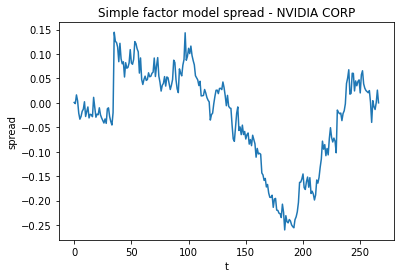

In [5]:
stock=2
plt.plot(SPREADS_SINGLE[:,stock])
plt.xlabel("t")
plt.ylabel("spread")
plt.title("Simple factor model spread - "+NAMES[stock])
plt.show()

- QUESTION 1

    - Multifactor factor model - OLS

In [6]:
SPREADS_OLS=np.zeros((n_obs,n_stocks))
for i in range(n_stocks):
    model=sm.OLS(STOCK_RETURNS[:,i],sm.add_constant(ETF_RETURNS))
    output=model.fit()
    betas_ols=output.params[1:]
    SPREADS_OLS[:,i]=np.cumsum(output.resid)

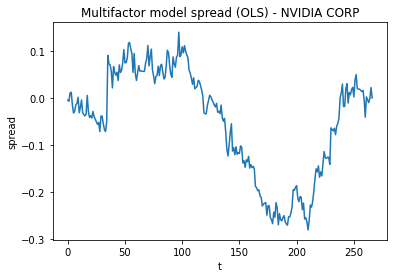

In [7]:
#stock=2
plt.plot(SPREADS_OLS[:,stock])
plt.xlabel("t")
plt.ylabel("spread")
plt.title("Multifactor model spread (OLS) - "+NAMES[stock])
plt.show()

- QUESTION 1

    - Multifactor factor model - RIDGE

In [8]:
SPREADS_RIDGE=np.zeros((n_obs,n_stocks))
lambda_range=np.array([i for i in np.arange(10/1000,1,10/1000)])
for i in range(n_stocks):
    model_ridge = RidgeCV(alphas=lambda_range, fit_intercept=True, normalize=False, scoring='neg_mean_squared_error',cv=None)
    results_ridge = model_ridge.fit(ETF_RETURNS,STOCK_RETURNS[:,i])
    betas_ridge=results_ridge.coef_
    cst_ridge=results_ridge.intercept_
    residuals_ridge=STOCK_RETURNS[:,i]-cst_ridge-np.dot(ETF_RETURNS,betas_ridge)
    SPREADS_RIDGE[:,i]=np.cumsum(residuals_ridge)

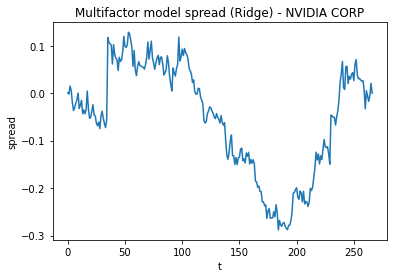

In [9]:
#stock=2
plt.plot(SPREADS_RIDGE[:,stock])
plt.xlabel("t")
plt.ylabel("spread")
plt.title("Multifactor model spread (Ridge) - "+NAMES[stock])
plt.show()

- QUESTION 1

    - Multifactor factor model - LASSO

In [32]:
SPREADS_LASSO=np.zeros((n_obs,n_stocks))
for i in range(n_stocks):
    lasso_out=lasso_path(ETF_RETURNS,STOCK_RETURNS[:,i])
    lambda_range=np.flipud(lasso_out[0])
    model_lasso = LassoCV(alphas=None, eps=0.001, n_alphas=100, fit_intercept=True, normalize=False, cv=None)
    results_lasso = model_lasso.fit(ETF_RETURNS,STOCK_RETURNS[:,i])
    betas_lasso=results_lasso.coef_
    cst_lasso=results_lasso.intercept_
    residuals_lasso=STOCK_RETURNS[:,i]-cst_lasso-np.dot(ETF_RETURNS,betas_lasso)
    SPREADS_LASSO[:,i]=np.cumsum(residuals_lasso)

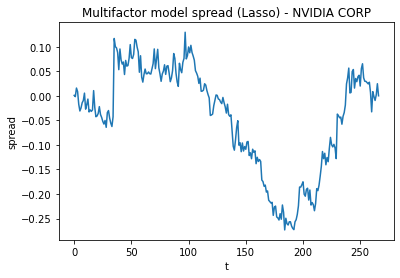

In [33]:
#stock=2
plt.plot(SPREADS_LASSO[:,stock])
plt.xlabel("t")
plt.ylabel("spread")
plt.title("Multifactor model spread (Lasso) - "+NAMES[stock])
plt.show()

- QUESTION 2 - NVIDIA CORP

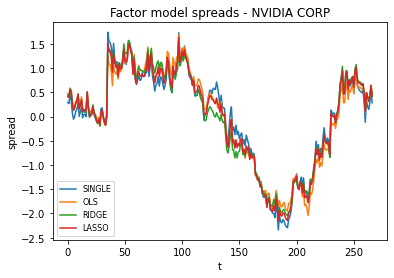

In [34]:
stock=2
SPREADS_SINGLE_N=preprocessing.scale(SPREADS_SINGLE, with_mean=1)
SPREADS_OLS_N=preprocessing.scale(SPREADS_OLS)
SPREADS_RIDGE_N=preprocessing.scale(SPREADS_RIDGE)
SPREADS_LASSO_N=preprocessing.scale(SPREADS_LASSO)
y1=plt.plot(SPREADS_SINGLE_N[:,stock],label="SINGLE")
y2=plt.plot(SPREADS_OLS_N[:,stock],label="OLS")
y3=plt.plot(SPREADS_RIDGE_N[:,stock],label="RIDGE")
y4=plt.plot(SPREADS_LASSO_N[:,stock],label="LASSO")
plt.xlabel("t")
plt.ylabel("spread")
plt.title("Factor model spreads - "+NAMES[stock])
plt.legend(loc="lower left", fontsize=8)
plt.show((y1,y2,y2,y4))

In [35]:
exposures=np.zeros((4,10))
exposures[0,7]=beta_single
exposures[1,:]=betas_ols
exposures[2,:]=betas_ridge
exposures[3,:]=betas_lasso
estimated_exposures= pd.DataFrame(data=exposures,columns=SECTORS, index=("SINGLE", "OLS", "RIDGE", "LASSO"))

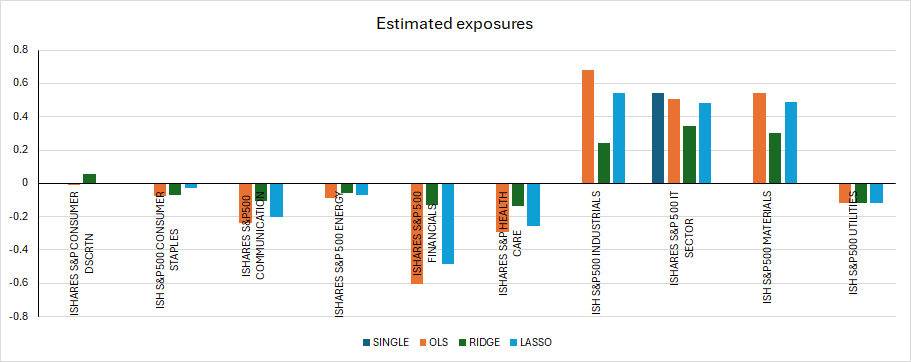

In [36]:
exp_stat=np.zeros((2,4))
exp_stat[0,:]=np.sum(estimated_exposures,axis=1)
exp_stat[1,:]=np.sum(abs(estimated_exposures),axis=1)
exp_stat_table=pd.DataFrame(data=exp_stat,columns=("SINGLE", "OLS", "RIDGE", "LASSO"), index=("sum exposures", "sum abs(exposures)"))
print(exp_stat_table)

                      SINGLE       OLS     RIDGE     LASSO
sum exposures       0.543677  0.308896  0.332975  0.361464
sum abs(exposures)  0.543677  3.145496  1.558024  2.669392
